In [ ]:
import pandas as pd
import numpy as np 

In [ ]:
# sklearn에서 캘리포니아 집값 예측 데이터셋 가져오기
from sklearn.datasets import fetch_california_housing

# numpy에서 소수점 4째 자리까지만 출력
np.set_printoptions(precision=4, suppress=True)

data = fetch_california_housing()

In [ ]:
# data의 특성을 확인
# 행의 갯수 : 20640
# 열의 특성 : 8 numeric
#print(data['DESCR'])

MedInc	: 구역 내 가구의 중간 소득 <br>
HouseAge :	구역 내 주택 연령의 중간값 <br>
AveRooms :	가구당 평균 방 개수<br>
AveBedrms :	가구당 평균 침실 개수<br>
Population :	구역 내 총 인구수<br>
AveOccup :	가구당 평균 인원수<br>
Latitude :	구역의 위도<br>
Longitude : 	구역의 경도<br>

In [ ]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df["MedHouseVal"] = data.target

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request

# 캘리포니아 지도 이미지 다운로드 (GitHub에서 바로 다운로드)
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png"
filename = "california.png"
print("Downloading california.png...")
urllib.request.urlretrieve(url, filename)
california_img = mpimg.imread(filename)

# 지도 시각화
ax = df.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(10,7),
             s=df['Population']/100, label="Population",
             c="MedHouseVal", cmap=plt.get_cmap("jet"),
             colorbar=False, alpha=0.4)

# 지도 이미지 오버레이 (coordinates based on the image extent)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# 가격 컬러바 추가
prices = df["MedHouseVal"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%.1f k"%(v) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [ ]:
df.head()

### 데이터 분할

In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

# 데이터셋 분할
data_train, data_test, target_train, target_test = train_test_split(df.drop("MedHouseVal", axis=1), df["MedHouseVal"], test_size=0.2, random_state=42)

# 데이터셋 확인
print("Training set size:", len(data_train))
print("Test set size:", len(data_test))


In [ ]:
# 회귀에 대한 평가 지표
# MSE, RMSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# plot_predictions : 예측값과 실제값을 산점도로 비교하여 시각화
def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

# mse 기준으로 모델의 성능 평가를 해주는 함수
def mse_eval(name_, pred, actual):
    global predictions
    global colors

    # 산점도를 그려주고(예측값, 정답값)
    plot_predictions(name_, pred, actual)

    # mse 계산 출력
    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    # 모델별 성능을 비교하기 위해 sorted
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    # 모델들을 비교해서 barh로 그려준다.
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

# 리스트에 있는 모델중에 하나를 삭제하는 함수
def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

### Model 1. LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

입력되는 변수(Variable)의 갯수가 beta값의 갯수를 좌우한다.

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7 + \beta_8 x_8$$

$$\mathbf{ h_\theta(x_{i}) = \theta_0+\theta_1 MedInc + \theta_2 HouseAge + \theta_3 AveRooms + \theta_4 AveBedrms + \theta_5 Population + \theta_6 AveOccup + \theta_7 Latitude + \theta_8 Longitude }$$

In [ ]:
# data_train, data_test, target_train, target_test

# 1. 모델 생성
model = LinearRegression()

# 2. 모델 학습
model.fit(data_train, target_train)

# 3. 모델 예측 : 예측값을 받아올때 
y_pred = model.predict(data_test)

# 4. 모델 평가
mse = mean_squared_error(target_test, y_pred)
mse

In [ ]:
print(model.coef_)
print(model.intercept_)

In [ ]:
# mse_eval 함수를 사용 : 모델을 리스트에 추가할때 모델명
mse_eval('LinearRegression', y_pred, target_test)

## 규제(Regularization , =penalty)
### L1 penalty, L2 penalty

**라쏘(Lasso) - L1 규제**  
$Error=MSE+α|w|$

**릿지(Ridge) - L2 규제** <br>
$Error=MSE+αw^2$ 


In [ ]:
# Lasso Regression : L1 penalty
# Ridge Regression : L2 penalty
from sklearn.linear_model import Ridge, Lasso

alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    # 1. 모델 생성
    model = Lasso(alpha=alpha)
    # 2. 모델 학습
    model.fit(data_train, target_train)
    # 3. 모델 예측
    y_pred = model.predict(data_test)
    # 4. 모델 평가
    mse = mean_squared_error(target_test, y_pred)
    mse_eval(f'Lasso alpha={alpha}', y_pred, target_test)

In [ ]:
alphas = [1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    # 1. 모델 생성
    model = Ridge(alpha=alpha)
    # 2. 모델 학습
    model.fit(data_train, target_train)
    # 3. 모델 예측
    y_pred = model.predict(data_test)
    # 4. 모델 평가
    mse = mean_squared_error(target_test, y_pred)
    mse_eval(f'Ridge alpha={alpha}', y_pred, target_test)

In [ ]:
# coef를 시각화하는 함수
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

In [ ]:
plot_coef(data_test.columns, model.coef_)

In [ ]:
# data_train, data_test, target_train, target_test


lasso_1 = Lasso(alpha=1)
lasso_1.fit(data_train, target_train)
lasso_pred_1 = lasso_1.predict(data_test)

lasso_001 = Lasso(alpha=0.001)
lasso_001.fit(data_train, target_train)
lasso_pred_001 = lasso_001.predict(data_test)

In [ ]:
plot_coef(data_train.columns, lasso_001.coef_)

### Lasso + Ridge -> ElasticNet

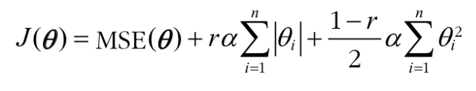

**l1_ratio (default=0.5)**

 * l1_ratio = 0 (L2 규제만 사용). 
 * l1_ratio = 1 (L1 규제만 사용). 
 * 0 < l1_ratio < 1 (L1 and L2 규제의 혼합사용)

In [ ]:
# # data_train, data_test, target_train, target_test

from sklearn.linear_model import ElasticNet

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

#l1_ratio의 값이 클때(L1의 비중을 크게 설정할때) 성능이 떨어질 수 있다.
for ratio in ratios:
    model = ElasticNet(alpha=0.5, l1_ratio=ratio, random_state=42)
    model.fit(data_train, target_train)
    y_pred = model.predict(data_test)
    print(f"Ratio: {ratio}, RMSE: {np.sqrt(mean_squared_error(target_test, y_pred))}")


In [ ]:
for ratio in ratios:
    elasticnet = ElasticNet(alpha=0.5, l1_ratio=ratio)
    elasticnet.fit(data_train, target_train)
    y_pred = elasticnet.predict(data_test)
    mse_eval('ElasticNet(l1_ratio={})'.format(ratio), y_pred, target_test)

### Scaler를 적용

In [ ]:
# # data_train, data_test, target_train, target_test

# Outlier에 강한 스케일러 순서 : RobustScaler > StandardScaler > MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

#데이터의 통계 분포
data_train.describe()

In [ ]:
# StandardScaler를 사용하여 스케일링
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(data_train)

In [ ]:
df_std_scaled =pd.DataFrame(data=std_scaled)
df_std_scaled.describe().round(4)

In [ ]:
#MinMaxScaler
minmax_scaler = MinMaxScaler()

#데이터 변환
minmax_scaled = minmax_scaler.fit_transform(data_train)

print("Min-Max Scaling 결과:")
df_minmax_scaled =pd.DataFrame(data=minmax_scaled)
df_minmax_scaled.describe().round(4)

In [ ]:
#MinMaxScaler
robust_scaler = RobustScaler()

#데이터 변환
robust_scaled = robust_scaler.fit_transform(data_train)

print("Min-Max Scaling 결과:")
df_robust_scaled =pd.DataFrame(data=robust_scaled)
df_robust_scaled.describe().round(4)

### 여러가지 조합을 만들기
make_pipeline를 사용하여 조합 만들기
1. StandardScaler + ElasticNet(l1_ratio=0.1)
2. RobustScaler + ElasticNet(l1_ratio=0.1)
3. MinMaxScaler + ElasticNet(l1_ratio=0.1)
4. 다항 회귀

In [ ]:
from sklearn.pipeline import Pipeline

# 1. 파이프라인(모델) 생성
std_scaled_elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000))
])

# data_train, data_test, target_train, target_test

# 2. 파이프라인(모델) 학습
std_scaled_elastic_pipeline.fit(data_train, target_train)

# 3. 파이프라인 예측
y_pred = std_scaled_elastic_pipeline.predict(data_test)

# 4. 파이프라인 평가
mse_eval('Std ElasticNet(alpha=0.001,l1_ratio=0.1)', y_pred, target_test)

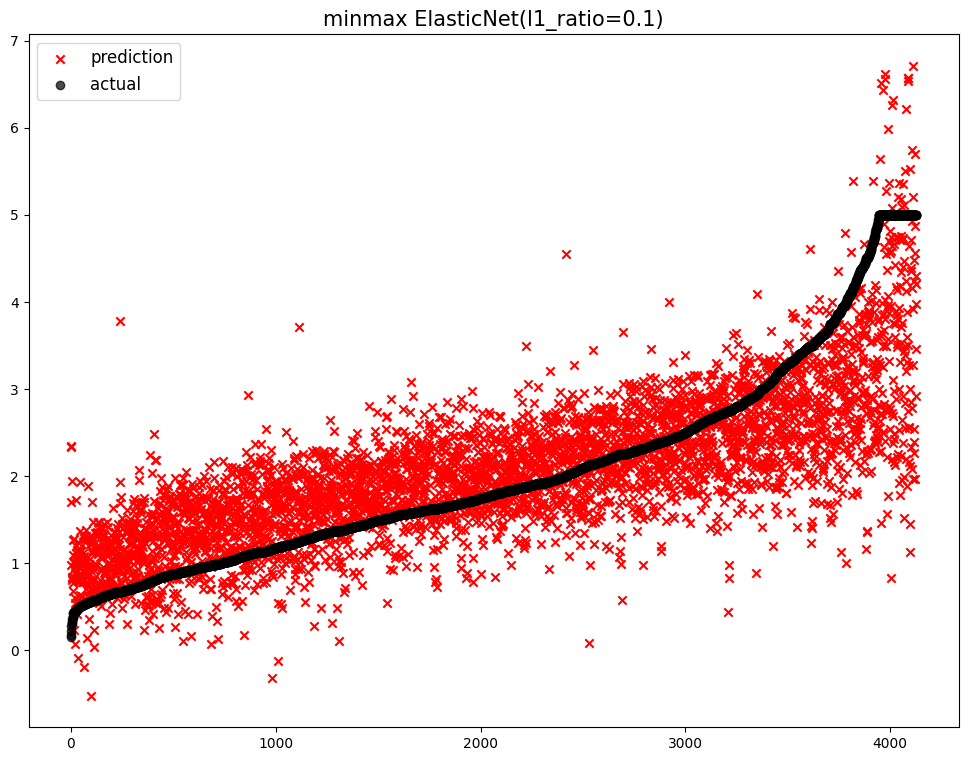

                              model       mse
0      Std ElasticNet(l1_ratio=0.1)  0.732531
1          ElasticNet(l1_ratio=0.9)  0.716693
2          ElasticNet(l1_ratio=0.7)  0.700064
3          ElasticNet(l1_ratio=0.5)  0.686873
4          ElasticNet(l1_ratio=0.3)  0.670324
5          ElasticNet(l1_ratio=0.1)  0.616577
6                  LinearRegression  0.555892
7                Ridge alpha=0.0001  0.555892
8                 Ridge alpha=0.001  0.555892
9                  Ridge alpha=0.01  0.555891
10                  Ridge alpha=0.1  0.555883
11                    Ridge alpha=1  0.555803
12  minmax ElasticNet(l1_ratio=0.1)  0.552847


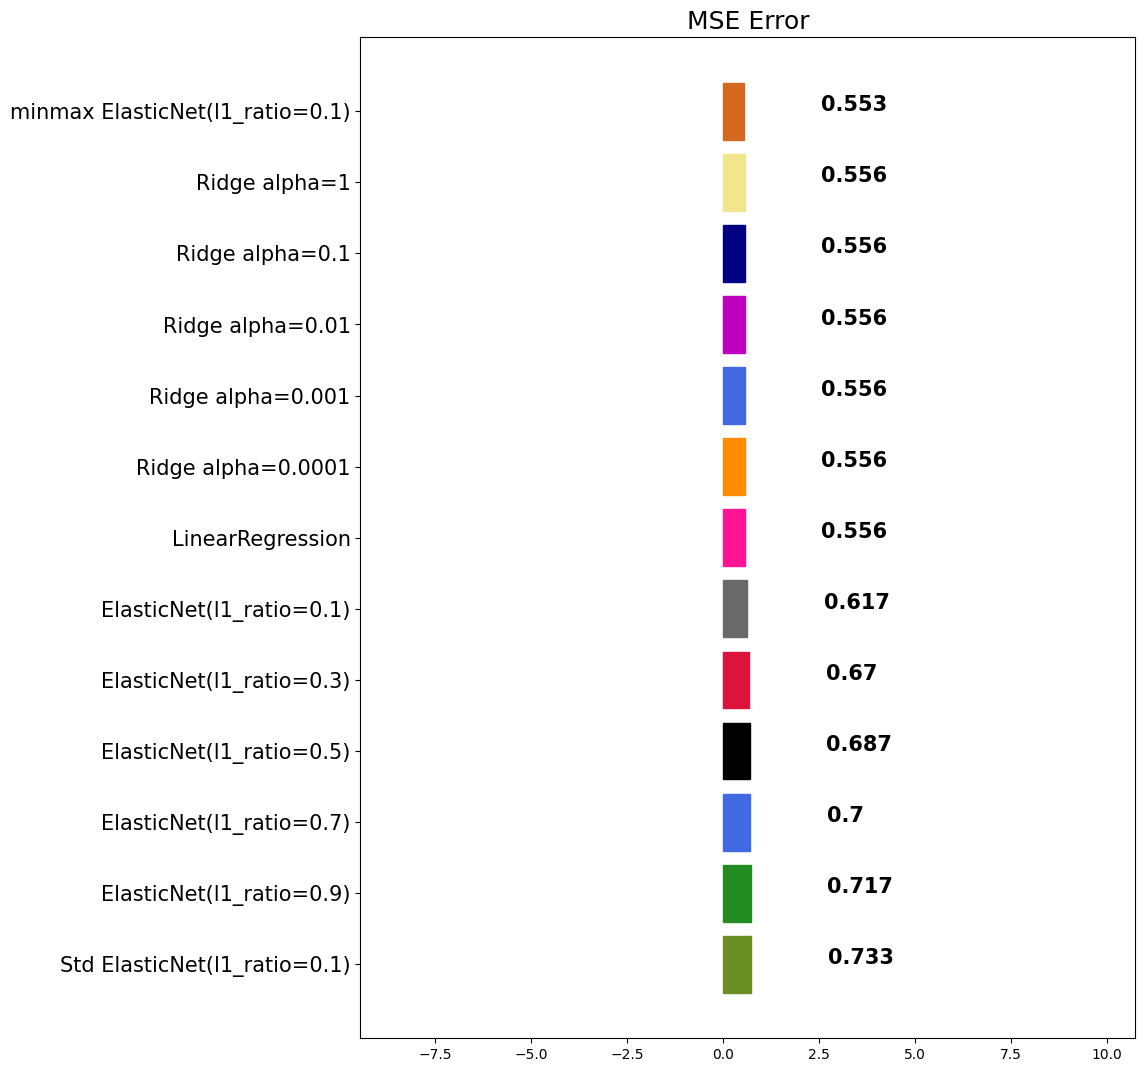

In [43]:
from sklearn.pipeline import Pipeline

# 1. 파이프라인(모델) 생성
minmax_scaled_elastic_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000))
])

# 2. 파이프라인(모델) 학습
minmax_scaled_elastic_pipeline.fit(data_train, target_train)

# 3. 파이프라인 예측
y_pred = minmax_scaled_elastic_pipeline.predict(data_test)

# 4. 파이프라인 평가
mse_eval('minmax ElasticNet(l1_ratio=0.1)', y_pred, target_test)